# Análisis de Ingresos en Planes Telefónicos de Megaline

Megaline es un operador de telecomunicaciones que ofrece múltiples productos, entre ellos destacan dos planes telefónicos con tarifas de prepago: **Surf y Ultimate**. El departamento comercial quiere saber **cuál de las tarifas genera más ingresos** para poder ajustar el presupuesto de publicidad.

El análisis se basará en datos de 500 clientes, proporcionando quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018.

Una anotación importante a considerar es que **Megaline redondea los segundos a minutos y los megabytes a gigabytes**:
- Para las llamadas, cada una individual se redondea incluso si la llamada **duró solo un segundo**, se contará como un minuto.
- Para el tráfico web, las sesiones individuales no se redondean, en vez de esto, el total del mes se redondea hacia arriba, es decir, si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes ya que cada uno equivale a 1024 megabytes.

Las tarifas y sus características son:

**Surf:**
- Pago mensual: $20.
- 500 minutos al mes, 50 SMS y 15 GB de datos.
- Si se exceden los límites del paquete:
    - 1 minuto: 3 centavos.
    - 1 SMS: 3 centavos.
    - 1 GB de datos: $10.

**Ultimate:**
- Pago mensual: $70.
- 3000 minutos al mes, 1000 SMS y 30 GB de datos.
- Si se exceden los límites del paquete:
    - 1 minuto: 1 centavo.
    - 1 SMS: 1 centavo.
    - 1 GB de datos: $7.

## Inicialización

In [54]:
# Cargar todas las librerías

import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st

## Cargar datos

In [55]:
# Carga los archivos de datos en diferentes DataFrames

df_users = pd.read_csv("../data/megaline_users.csv")
df_calls = pd.read_csv("../data/megaline_calls.csv")
df_messages = pd.read_csv("../data/megaline_messages.csv")
df_internet = pd.read_csv("../data/megaline_internet.csv")
df_plans = pd.read_csv("../data/megaline_plans.csv")

## Tarifas

In [56]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()

<class 'pandas.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      str    
dtypes: float64(2), int64(5), str(1)
memory usage: 260.0 bytes


In [57]:
# Imprime una muestra de los datos para las tarifas

print(df_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


En el DataFrame de los planes se observa:

1. No hay datos nulos o ausentes.
2. Los tipos dato son coherentes con los datos de cada columna.
3. Es posible que los encabezados `usd_per_gb`, `usd_per_message` y `usd_per_minute` no se comprenda que es por exceder lo que el plan ofrece. Se modificará el nombre agregando `extra`.
4. En la descripción de las tarifas de los planes y sus excedentes, se anuncian GB y no MB, por lo cual, se hara la conversión en esa columna.

## Corregir datos

In [58]:
df_plans.rename(columns={"mb_per_month_included" : "gb_per_month_included",
                        "usd_per_gb" : "usd_per_gb_extra",
                        "usd_per_message" : "usd_per_message_extra",
                        "usd_per_minute" : "usd_per_minute_extra"}, inplace=True) # Renombre de los encabezados.
df_plans["gb_per_month_included"] = df_plans["gb_per_month_included"].apply(lambda x : math.ceil(x/1024)) # Conversión mb a gb.

print(df_plans)

   messages_included  gb_per_month_included  minutes_included  \
0                 50                     15               500   
1               1000                     30              3000   

   usd_monthly_pay  usd_per_gb_extra  usd_per_message_extra  \
0               20                10                   0.03   
1               70                 7                   0.01   

   usd_per_minute_extra plan_name  
0                  0.03      surf  
1                  0.01  ultimate  


## Usuarios/as

In [59]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

df_users.info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user_id     500 non-null    int64
 1   first_name  500 non-null    str  
 2   last_name   500 non-null    str  
 3   age         500 non-null    int64
 4   city        500 non-null    str  
 5   reg_date    500 non-null    str  
 6   plan        500 non-null    str  
 7   churn_date  34 non-null     str  
dtypes: int64(2), str(6)
memory usage: 31.4 KB


In [60]:
# Imprime una muestra de datos para usuarios

print(df_users.sample(5))

     user_id first_name  last_name  age  \
30      1030      Chase       Kane   30   
21      1021    Ricarda     Booker   37   
408     1408     Alaine  Robertson   40   
12      1012    Jonelle    Mcbride   59   
217     1217        Ned     Thomas   69   

                                       city    reg_date      plan  churn_date  
30   Chicago-Naperville-Elgin, IL-IN-WI MSA  2018-02-14  ultimate         NaN  
21   Los Angeles-Long Beach-Anaheim, CA MSA  2018-12-21      surf         NaN  
408       Baltimore-Columbia-Towson, MD MSA  2018-01-11      surf         NaN  
12   Chicago-Naperville-Elgin, IL-IN-WI MSA  2018-06-28      surf  2018-11-16  
217                Dayton-Kettering, OH MSA  2018-06-04      surf         NaN  


Tras observar la información del DataFrame y ver sus datos, se observa:

1. Únicamente la columna `churn_date` cuenta con valores nulos, bastantes para el número de datos. Tras leer la descripción de estos datos, vemos que en la mayoria, de los registros, se usaba la tarifa.
2. Los tipos de datos de las columnas son coherentes con sus datos a excepción de `reg_date` y `churn_date`, por lo que se cambiará al tipo datetime.

### Corregir los datos

In [61]:
df_users["reg_date"] = pd.to_datetime(df_users["reg_date"], format="%Y-%m-%d") # Transformación del tipo de dato para la primera columna.
df_users["churn_date"] = pd.to_datetime(df_users["churn_date"], format="%Y-%m-%d") # Transformación del tipo de dato para la segunda columna.

df_users.info() # Confirmación de los cambios.

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    str           
 2   last_name   500 non-null    str           
 3   age         500 non-null    int64         
 4   city        500 non-null    str           
 5   reg_date    500 non-null    datetime64[us]
 6   plan        500 non-null    str           
 7   churn_date  34 non-null     datetime64[us]
dtypes: datetime64[us](2), int64(2), str(4)
memory usage: 31.4 KB


In [62]:
print("Filas totalmente duplicadas:", df_users.duplicated().sum()) # Aseguración de que no haya filas totalmente duplicadas.
print("Usuarios duplicados:", df_users["user_id"].duplicated().sum()) # Aseguración de que los usuarios no estén repetidos.

Filas totalmente duplicadas: 0
Usuarios duplicados: 0


## Llamadas

In [63]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

df_calls.info()

<class 'pandas.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  str    
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  str    
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), str(2)
memory usage: 4.2 MB


In [64]:
# Imprime una muestra de datos para las llamadas

print(df_calls.sample(5))

              id  user_id   call_date  duration
105067  1370_162     1370  2018-10-06      7.88
88342   1324_391     1324  2018-08-22      3.33
104572  1368_276     1368  2018-06-24      8.36
133805   1485_12     1485  2018-12-31      9.25
132296  1476_239     1476  2018-09-11     11.83


Tras la revisión del DataFrame de las llamadas, se observa lo siguiente:

1. No se cuentan con datos nulos en ninguna columna.
2. Los tipo de dato son consistentes con datos a excepción de `call_date`, por lo que aquí también se cambiará a datetime.

### Corregir los datos

In [65]:
df_calls["call_date"] = pd.to_datetime(df_calls["call_date"], format="%Y-%m-%d") # Transformación del tipo de dato de la columna.

df_calls.info() # Confirmación de los cambios.

<class 'pandas.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  str           
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[us]
 3   duration   137735 non-null  float64       
dtypes: datetime64[us](1), float64(1), int64(1), str(1)
memory usage: 4.2 MB


In [66]:
print("Filas totalmente duplicadas:", df_calls.duplicated().sum()) # Aseguración de que no haya filas totalmente duplicadas.
print("id's de llamadas duplicados:", df_calls["id"].duplicated().sum()) # Aseguración de que los id's no estén repetidos.

Filas totalmente duplicadas: 0
id's de llamadas duplicados: 0


In [67]:
# Dado que cada llamada individual se redondea hacia el minuto de arriba, se ajustará de una vez el df.

df_calls["duration"] = df_calls["duration"].apply(lambda x : math.ceil(x))

In [68]:
print(df_calls.sample(5))

              id  user_id  call_date  duration
130906  1470_355     1470 2018-07-13         5
76410    1271_33     1271 2018-12-09         7
114494  1401_216     1401 2018-12-09        13
50664     1183_8     1183 2018-11-18        13
59946   1215_331     1215 2018-12-26        12


## Mensajes

In [69]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

df_messages.info()

<class 'pandas.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            76051 non-null  str  
 1   user_id       76051 non-null  int64
 2   message_date  76051 non-null  str  
dtypes: int64(1), str(2)
memory usage: 1.7 MB


In [70]:
# Imprime una muestra de datos para los mensajes

print(df_messages.sample(5))

             id  user_id message_date
53387  1339_521     1339   2018-12-08
54418  1343_519     1343   2018-12-18
7211    1059_82     1059   2018-12-18
67812  1439_206     1439   2018-10-09
31540   1196_20     1196   2018-03-28


Tras revisar la información del DataFrame de los SMS, se observa:

1. No se tienen valores nulos.
2. Se requiere cambiar el tipo de dato a `message_date`.

### Corregir los datos

In [71]:
df_messages["message_date"] = pd.to_datetime(df_messages["message_date"], format="%Y-%m-%d") # Transformación del tipo de dato de la columna.

df_messages.info() # Confirmación de los cambios.

<class 'pandas.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  str           
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), str(1)
memory usage: 1.7 MB


In [72]:
print("Filas totalmente duplicadas:", df_messages.duplicated().sum()) # Aseguración de que no haya filas totalmente duplicadas.
print("id's de SMS duplicados:", df_messages["id"].duplicated().sum()) # Aseguración de que los id's no estén repetidos.

Filas totalmente duplicadas: 0
id's de SMS duplicados: 0


## Internet

In [73]:
# Imprime la información general/resumida sobre el DataFrame de internet

df_internet.info()

<class 'pandas.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  str    
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  str    
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), str(2)
memory usage: 3.2 MB


In [74]:
# Imprime una muestra de datos para el tráfico de internet

print(df_internet.sample(5))

              id  user_id session_date  mb_used
24826   1114_136     1114   2018-08-16   658.92
50225   1223_435     1223   2018-08-31     0.00
82447   1385_198     1385   2018-11-13  1030.10
74126   1347_221     1347   2018-09-25     0.00
101076  1478_227     1478   2018-12-26   417.63


Tras revisar el DataFrame sobre las sesiones WEB, se observa:

1. Tampoco hay valores nulos.
2. Nuevamente se debe cambiar el tipo de dato a la columna `session_date` por datatime.

### Corregir los datos

In [75]:
df_internet["session_date"] = pd.to_datetime(df_internet["session_date"], format="%Y-%m-%d") # Transformación del tipo de dato de la columna.

df_internet.info() # Confirmación de los cambios.

<class 'pandas.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  str           
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[us]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[us](1), float64(1), int64(1), str(1)
memory usage: 3.2 MB


In [76]:
print("Filas totalmente duplicadas:", df_internet.duplicated().sum()) # Aseguración de que no haya filas totalmente duplicadas.
print("id's de sesiones WEB duplicados:", df_internet["id"].duplicated().sum()) # Aseguración de que los id's no estén repetidos.

Filas totalmente duplicadas: 0
id's de sesiones WEB duplicados: 0


In [77]:
df_internet["gb_used"] = df_internet["mb_used"] / 1024 # Sea crea una columna al df que es la conversión a GB de los MB.
print(df_internet.sample(5))

             id  user_id session_date  mb_used   gb_used
95028   1443_98     1443   2018-12-25   583.07  0.569404
76402   1359_81     1359   2018-08-24   462.37  0.451533
15319  1069_201     1069   2018-11-01   254.45  0.248486
38905  1174_168     1174   2018-07-01   595.31  0.581357
39705   1179_36     1179   2018-09-06     0.00  0.000000


## Estudiar las condiciones de las tarifas

In [78]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

print(df_plans)

   messages_included  gb_per_month_included  minutes_included  \
0                 50                     15               500   
1               1000                     30              3000   

   usd_monthly_pay  usd_per_gb_extra  usd_per_message_extra  \
0               20                10                   0.03   
1               70                 7                   0.01   

   usd_per_minute_extra plan_name  
0                  0.03      surf  
1                  0.01  ultimate  


## Agregar datos por usuario

In [79]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

# El plan es crear un df con tres columnas: call_month, user_id, calls_numbers.
# Es decir, un df con el número de llamadas por usuarios al mes, para esto:
# 1. Se creará una tabla dinámica usando del df de las llamadas.
# 2. Se transformará la tabla en formato largo.
# 3. Se obtendrán nulos en calls_numbers, estos serán porque en ese mes, el usuario no registró llamadas, por lo que se pueden eliminar. 
# 4. Se comprobará que el número de llamadas del df original sea el mismo que el del nuevo df.

df_monthly_calls_h = df_calls.pivot_table(index = df_calls["call_date"].dt.to_period("M"), # Creación de tabla dinámica.
                                         columns = "user_id",
                                         values = "id",
                                         aggfunc = "count")

df_monthly_calls_h.reset_index(inplace=True) # Los índices que son los meses, se pasan a una columna.

df_monthly_calls_v = df_monthly_calls_h.melt(id_vars = "call_date", # Transformación de la tabla dinámica a formato largo.
                                            var_name = "user_id",
                                            value_name = "calls_number")

df_monthly_calls_v.dropna(subset=["calls_number"], inplace=True) # Eliminación de nulos porque no son relevantes.
df_monthly_calls_v.rename(columns={"call_date" : "calls_month"}, inplace=True) # Renombre de columna.
df_monthly_calls_v.index = range(len(df_monthly_calls_v)) # Reseteo de índice.

check_1 = len(df_calls) == df_monthly_calls_v["calls_number"].sum() # Elaboración de comprobación.

print(df_monthly_calls_v) # Nuevo df resultante.
print()
print("Comprobación: ", check_1) # Confirmación de comprobación.

     calls_month user_id  calls_number
0        2018-12    1000          16.0
1        2018-08    1001          27.0
2        2018-09    1001          49.0
3        2018-10    1001          65.0
4        2018-11    1001          64.0
...          ...     ...           ...
2253     2018-12    1498          39.0
2254     2018-09    1499          41.0
2255     2018-10    1499          53.0
2256     2018-11    1499          45.0
2257     2018-12    1499          65.0

[2258 rows x 3 columns]

Comprobación:  True


In [80]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

# El plan a seguir es el mismo que en la línea anterior.

df_monthly_calls_minutes_h = df_calls.pivot_table(index = df_calls["call_date"].dt.to_period("M"), # Creación de tabla dinámica.
                                                 columns = "user_id",
                                                 values = "duration",
                                                 aggfunc = "sum")

df_monthly_calls_minutes_h.reset_index(inplace=True) # Los índices que son los meses, se pasan a una columna.

df_monthly_calls_minutes_v = df_monthly_calls_minutes_h.melt(id_vars = "call_date", # Transformación de la tabla dinámica a formato largo.
                                                            var_name = "user_id",
                                                            value_name = "calls_duration")

df_monthly_calls_minutes_v.dropna(subset=["calls_duration"], inplace=True) # Eliminación de nulos porque no son relevantes.
df_monthly_calls_minutes_v.rename(columns={"call_date" : "calls_month"}, inplace=True) # Renombre de columna.
df_monthly_calls_minutes_v.index = range(len(df_monthly_calls_minutes_v)) # Reseteo de índice.

check_2 = df_calls["duration"].sum().round(2) == df_monthly_calls_minutes_v["calls_duration"].sum() # Elaboración de comprobación y se aplica redondeo ya que la suma arroja 929150.2599999998, es decir, prácticamente 929150.26.  

print(df_monthly_calls_minutes_v) # Nuevo df resultante.
print()
print("Comprobación: ", check_2) # Confirmación de comprobación.

     calls_month user_id  calls_duration
0        2018-12    1000           124.0
1        2018-08    1001           182.0
2        2018-09    1001           315.0
3        2018-10    1001           393.0
4        2018-11    1001           426.0
...          ...     ...             ...
2253     2018-12    1498           339.0
2254     2018-09    1499           346.0
2255     2018-10    1499           385.0
2256     2018-11    1499           308.0
2257     2018-12    1499           496.0

[2258 rows x 3 columns]

Comprobación:  True


In [81]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

# El plan a seguir es el mismo que en la línea anterior.

df_monthly_messages_h = df_calls.pivot_table(index = df_messages["message_date"].dt.to_period("M"), # Creación de tabla dinámica.
                                         columns = "user_id",
                                         values = "id",
                                         aggfunc = "count")

df_monthly_messages_h.reset_index(inplace=True) # Los índices que son los meses, se pasan a una columna.

df_monthly_messages_v = df_monthly_messages_h.melt(id_vars = "message_date", # Transformación de la tabla dinámica a formato largo.
                                                    var_name = "user_id",
                                                    value_name = "messages_number")

df_monthly_messages_v.dropna(subset=["messages_number"], inplace=True) # Eliminación de nulos porque no son relevantes.
df_monthly_messages_v.rename(columns={"message_date" : "messages_month"}, inplace=True) # Renombre de columna.
df_monthly_messages_v.index = range(len(df_monthly_messages_v)) # Reseteo de índice.

check_3 = len(df_messages) == df_monthly_messages_v["messages_number"].sum() # Elaboración de comprobación.  

print(df_monthly_messages_v) # Nuevo df resultante.
print()
print("Comprobación: ", check_3) # Confirmación de comprobación.

     messages_month user_id  messages_number
0           2018-08    1000              1.0
1           2018-10    1000              1.0
2           2018-11    1000              2.0
3           2018-12    1000             12.0
4           2018-08    1001             29.0
...             ...     ...              ...
1892        2018-08    1268             46.0
1893        2018-09    1268             68.0
1894        2018-10    1268            105.0
1895        2018-11    1268             92.0
1896        2018-12    1268            149.0

[1897 rows x 3 columns]

Comprobación:  True


In [82]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

# El plan a seguir es el mismo que en la línea anterior.

df_monthly_internet_h = df_internet.pivot_table(index = df_internet["session_date"].dt.to_period("M"), # Creación de tabla dinámica.
                                                 columns = "user_id",
                                                 values = "gb_used",
                                                 aggfunc = "sum")

df_monthly_internet_h.reset_index(inplace=True) # Los índices que son los meses, se pasan a una columna.

df_monthly_internet_v = df_monthly_internet_h.melt(id_vars = "session_date", # Transformación de la tabla dinámica a formato largo.
                                                    var_name = "user_id",
                                                    value_name = "gb_used")

df_monthly_internet_v.dropna(subset=["gb_used"], inplace=True) # Eliminación de nulos porque no son relevantes.
df_monthly_internet_v.rename(columns={"session_date" : "sessions_month"}, inplace=True) # Renombre de columna.
df_monthly_internet_v.index = range(len(df_monthly_internet_v)) # Reseteo de índice.

check_4 = df_internet["gb_used"].sum() == df_monthly_internet_v["gb_used"].sum().round(2) # Elaboración de comprobación.  

print(df_monthly_internet_v) # Nuevo df resultante.
print()
print("Comprobación: ", check_4) # Confirmación de comprobación.
df_monthly_internet_v.info()

     sessions_month user_id    gb_used
0           2018-12    1000   1.856904
1           2018-08    1001   6.756982
2           2018-09    1001  13.002754
3           2018-10    1001  21.807119
4           2018-11    1001  18.070605
...             ...     ...        ...
2272        2018-12    1498  22.595400
2273        2018-09    1499  12.680430
2274        2018-10    1499  19.035576
2275        2018-11    1499  16.419756
2276        2018-12    1499  21.542197

[2277 rows x 3 columns]

Comprobación:  False
<class 'pandas.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   sessions_month  2277 non-null   period[M]
 1   user_id         2277 non-null   object   
 2   gb_used         2277 non-null   float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 53.5+ KB


In [83]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

# Ninguno de los últimos 4 df contiene un id único que permita unir los datos para cada combinación month-user.
# El plan a seguir es:
# 1. Convertir los tipo de dato de las columnas month y user a object para lograr una óptima concatenación.
# 2. Para cada uno de estos 4 df, se creará una nueva columna concatenando month con user, esto formará los id's únicos.
# 3. Se unirán con .merge() los 4 df por medio del id creado.
# 4. Se creará el df final tomando solamente las columnas de interés.
# 5. Se revisarán y trataran los nulos obtenidos.
# 6. Se convertirán los tipos de datos a los correctos.

# df con el número de llamadas hechas.
df_monthly_calls_v["calls_month"] = df_monthly_calls_v["calls_month"].astype(str) # Cambio de tipo de dato.
df_monthly_calls_v["user_id"] = df_monthly_calls_v["user_id"].astype(str) # Cambio de tipo de dato.
df_monthly_calls_v["id_month_user"] = df_monthly_calls_v["calls_month"] + "_" + df_monthly_calls_v["user_id"] # Concatenación.

print(df_monthly_calls_v.sort_values("user_id").head())
print()

# df con la cantidad de minutos.
df_monthly_calls_minutes_v["calls_month"] = df_monthly_calls_minutes_v["calls_month"].astype(str) # Cambio de tipo de dato.
df_monthly_calls_minutes_v["user_id"] = df_monthly_calls_minutes_v["user_id"].astype(str) # Cambio de tipo de dato.
df_monthly_calls_minutes_v["id_month_user"] = df_monthly_calls_minutes_v["calls_month"] + "_" + df_monthly_calls_minutes_v["user_id"] # Concatenación.

print(df_monthly_calls_minutes_v.sort_values("user_id").head())
print()

# df con el número de SMS.
df_monthly_messages_v["messages_month"] = df_monthly_messages_v["messages_month"].astype(str) # Cambio de tipo de dato.
df_monthly_messages_v["user_id"] = df_monthly_messages_v["user_id"].astype(str) # Cambio de tipo de dato.
df_monthly_messages_v["id_month_user"] = df_monthly_messages_v["messages_month"] + "_" + df_monthly_messages_v["user_id"] # Concatenación.

print(df_monthly_messages_v.sort_values("user_id").head())
print()

# df con la cantidad de mb.
df_monthly_internet_v["sessions_month"] = df_monthly_internet_v["sessions_month"].astype(str) # Cambio de tipo de dato.
df_monthly_internet_v["user_id"] = df_monthly_internet_v["user_id"].astype(str) # Cambio de tipo de dato.
df_monthly_internet_v["id_month_user"] = df_monthly_internet_v["sessions_month"] + "_" + df_monthly_internet_v["user_id"] # Concatenación.

print(df_monthly_internet_v.sort_values("user_id").head())
print()

  calls_month user_id  calls_number id_month_user
0     2018-12    1000          16.0  2018-12_1000
1     2018-08    1001          27.0  2018-08_1001
2     2018-09    1001          49.0  2018-09_1001
3     2018-10    1001          65.0  2018-10_1001
4     2018-11    1001          64.0  2018-11_1001

  calls_month user_id  calls_duration id_month_user
0     2018-12    1000           124.0  2018-12_1000
1     2018-08    1001           182.0  2018-08_1001
2     2018-09    1001           315.0  2018-09_1001
3     2018-10    1001           393.0  2018-10_1001
4     2018-11    1001           426.0  2018-11_1001

  messages_month user_id  messages_number id_month_user
0        2018-08    1000              1.0  2018-08_1000
1        2018-10    1000              1.0  2018-10_1000
2        2018-11    1000              2.0  2018-11_1000
3        2018-12    1000             12.0  2018-12_1000
4        2018-08    1001             29.0  2018-08_1001

  sessions_month user_id    gb_used id_month_user

In [84]:
# merge_1 = pd.merge(df_monthly_calls_v, df_monthly_calls_minutes_v, on="id_month_user", how="outer") # Unión de los primeros dos df por medio del id month-user.
# merge_2 = pd.merge(merge_1, df_monthly_messages_v, on="id_month_user", how="outer") # Unión del resultado de la línea de arriba con el tercer df.
# merge_3 = pd.merge(merge_2, df_monthly_internet_v, on="id_month_user", how="outer") # Unión del resultado de la línea de arriba con el cuarto df.
# print(merge_3) # Visualización de df resultante.

# Mantén user_id solo en el DF base (o elimínalo de todos si ya está embebido en id_month_user)
df_monthly_calls_v = df_monthly_calls_v.copy()
df_monthly_calls_minutes_v = df_monthly_calls_minutes_v.drop(columns=["user_id"], errors="ignore")
df_monthly_messages_v = df_monthly_messages_v.drop(columns=["user_id"], errors="ignore")
df_monthly_internet_v = df_monthly_internet_v.drop(columns=["user_id"], errors="ignore")

merge_1 = pd.merge(df_monthly_calls_v, df_monthly_calls_minutes_v, on="id_month_user", how="outer")
merge_2 = pd.merge(merge_1, df_monthly_messages_v, on="id_month_user", how="outer")
merge_3 = pd.merge(merge_2, df_monthly_internet_v, on="id_month_user", how="outer")

print(merge_3)


     calls_month_x user_id  calls_number id_month_user calls_month_y  \
0          2018-01    1042          18.0  2018-01_1042       2018-01   
1              NaN     NaN           NaN  2018-01_1048           NaN   
2              NaN     NaN           NaN  2018-01_1049           NaN   
3              NaN     NaN           NaN  2018-01_1050           NaN   
4          2018-01    1077          42.0  2018-01_1077       2018-01   
...            ...     ...           ...           ...           ...   
3037       2018-12    1495          65.0  2018-12_1495       2018-12   
3038       2018-12    1496          40.0  2018-12_1496       2018-12   
3039       2018-12    1497          54.0  2018-12_1497       2018-12   
3040       2018-12    1498          39.0  2018-12_1498       2018-12   
3041       2018-12    1499          65.0  2018-12_1499       2018-12   

      calls_duration messages_month  messages_number sessions_month    gb_used  
0              114.0            NaN              NaN  

In [85]:
# La unión no nos dió una columna de month o user completa (sin nulos), esto es escencial
# ya que cada línea debe contener estos datos.
# Esto se debe a que los usuarios en el mes x, solo usaron al menos un servicio, por lo cual,
# los servicios que no se se usaron aparecen como nulos.
# Para devolver month y user por separado a cada línea, se usará un método de string para deshacer la concatenación.

merge_3[["month", "user_id"]] = merge_3["id_month_user"].str.split("_", expand=True) # Se deshace la concatenación.
df_monthly_usage = merge_3[["id_month_user", "month", "user_id", "calls_number", "calls_duration", "messages_number", "gb_used"]] # Se crea el df final solo con las columnas de interés.

print(df_monthly_usage)
df_monthly_usage.info()

     id_month_user    month user_id  calls_number  calls_duration  \
0     2018-01_1042  2018-01    1042          18.0           114.0   
1     2018-01_1048  2018-01    1048           NaN             NaN   
2     2018-01_1049  2018-01    1049           NaN             NaN   
3     2018-01_1050  2018-01    1050           NaN             NaN   
4     2018-01_1077  2018-01    1077          42.0           290.0   
...            ...      ...     ...           ...             ...   
3037  2018-12_1495  2018-12    1495          65.0           492.0   
3038  2018-12_1496  2018-12    1496          40.0           294.0   
3039  2018-12_1497  2018-12    1497          54.0           300.0   
3040  2018-12_1498  2018-12    1498          39.0           339.0   
3041  2018-12_1499  2018-12    1499          65.0           496.0   

      messages_number    gb_used  
0                 NaN   1.811455  
1                 6.0        NaN  
2                23.0        NaN  
3                 8.0        Na

In [86]:
# Como se explicó en lo comentarios anteriores, hay usuarios que en un mes determinado usaron almenos un servicio, así,
# por la construcción del df, los servicios que no usaron están como NaN pero el valor más correcto es 0.
# Antes, nótese que no debería haber ningún registro con 4 nulos en las 4 columnas con los consumos:

columns_to_check_5 = ["calls_number", "calls_duration", "messages_number", "gb_used"] # Las 4 columnas de interés para verificar nulos.
check_5 =  df_monthly_usage[df_monthly_usage[columns_to_check_5].isna().sum(axis=1) == 4] # Comprobación de que no hay filas con 4 nulos.

print(check_5)

Empty DataFrame
Columns: [id_month_user, month, user_id, calls_number, calls_duration, messages_number, gb_used]
Index: []


In [87]:
df_monthly_usage.fillna(0, inplace=True) # Reemplazo de Nan por 0.

df_monthly_usage = df_monthly_usage.astype({"month" : "period[M]", # Transformación a los tipos de datos correctos para cada columna.
                                           "user_id" : "int",
                                           "calls_number" : "int",
                                           "calls_duration" : "float",
                                           "messages_number" : "int"})

print(df_monthly_usage)
df_monthly_usage.info()

     id_month_user    month  user_id  calls_number  calls_duration  \
0     2018-01_1042  2018-01     1042            18           114.0   
1     2018-01_1048  2018-01     1048             0             0.0   
2     2018-01_1049  2018-01     1049             0             0.0   
3     2018-01_1050  2018-01     1050             0             0.0   
4     2018-01_1077  2018-01     1077            42           290.0   
...            ...      ...      ...           ...             ...   
3037  2018-12_1495  2018-12     1495            65           492.0   
3038  2018-12_1496  2018-12     1496            40           294.0   
3039  2018-12_1497  2018-12     1497            54           300.0   
3040  2018-12_1498  2018-12     1498            39           339.0   
3041  2018-12_1499  2018-12     1499            65           496.0   

      messages_number    gb_used  
0                   0   1.811455  
1                   6   0.000000  
2                  23   0.000000  
3                  

In [88]:
# Hasta este punto ya se tiene un df con los consumos mensuales por usuario, es hora de redondear los GB usados
# tal como la descripción de las tarifas lo pide

df_monthly_usage["gb_used"] = df_monthly_usage["gb_used"].apply(lambda x : math.ceil(x))

In [89]:
# A nuestro último df solo le hace falta que se agregue el plan en base al usuario.
# Para conseguir esto se unirá con .merge() la columna del plan del df de los usuarios.

df_monthly_usage_plan = pd.merge(df_monthly_usage, df_users[["user_id", "plan", "city"]], on="user_id", how="left") # Unión del df actado con el df del uso por usuario de los planes.

print(df_monthly_usage_plan.sample(10)) # Visualizamos el nuevo df.

     id_month_user    month  user_id  calls_number  calls_duration  \
1136  2018-08_1168  2018-08     1168             0             0.0   
1564  2018-09_1265  2018-09     1265             0             0.0   
2585  2018-12_1022  2018-12     1022            82           585.0   
788   2018-07_1101  2018-07     1101            47           302.0   
1320  2018-08_1494  2018-08     1494            78           486.0   
240   2018-04_1334  2018-04     1334           104           795.0   
828   2018-07_1151  2018-07     1151             0             0.0   
2231  2018-11_1130  2018-11     1130            80           586.0   
2847  2018-12_1290  2018-12     1290             8            51.0   
304   2018-05_1084  2018-05     1084             0             0.0   

      messages_number  gb_used  plan  \
1136                5        0  surf   
1564                9        0  surf   
2585              213       18  surf   
788                46       14  surf   
1320                0       1

In [90]:
# Calcula el ingreso mensual para cada usuario

# El plan será agregar al último df creado que ya muestra los consumos mensuales por usuario:
# 1. Una serie de columna que indiquen cuánto extra del plan se consumió en minutos, SMS y GB considerando los redondeos hacia arriba.
# 2. Después y en base a las tarifas de los planes, a cuántos usd corresponde el extra.
# 3. Agregar al costo del plan, la suma de todos los extras para obtener el ingreso mensual por usuario.
# Esto es posible conseguir con las funciones lambda y el método .apply().
# Además, se considera que esta tabla ayudará a comprobar sobre una misma línea el desgloce de los costos y las operaciones.

df_monthly_usage_plan["calls_duration_extra"] = df_monthly_usage_plan.apply(lambda row : math.ceil(max(0, row["calls_duration"] - 500)) if row["plan"] == "surf" else math.ceil(max(0, row["calls_duration"] - 3000)), axis = 1) # Creación de columna con consumo extra al plan en minutos en llamadas. Toma en cuenta el redondeo de minutos y tipo de plan.
df_monthly_usage_plan["messages_number_extra"] = df_monthly_usage_plan.apply(lambda row : max(0, row["messages_number"] - 50) if row["plan"] == "surf" else max(0, row["messages_number"] - 1000), axis = 1) # Creación de columna con consumo extra al plan en SMS's. Toma en cuenta el tipo de plan.
df_monthly_usage_plan["gb_used_extra"] = df_monthly_usage_plan.apply(lambda row : max(0, row["gb_used"] - 15) if row["plan"] == "surf" else max(0, row["gb_used"] - 30), axis = 1) # Creación de columna con consumo extra al plan en GB. Toma en cuenta el tipo de plan.

df_monthly_usage_plan["calls_cost_extra"] = df_monthly_usage_plan.apply(lambda row : row["calls_duration_extra"] * 0.03 if row["plan"] == "surf" else row["calls_duration_extra"] * 0.01, axis = 1) # Dependiendo del plan, calcula el costo por los minutos extras.
df_monthly_usage_plan["messages_cost_extra"] = df_monthly_usage_plan.apply(lambda row : row["messages_number_extra"] * 0.03 if row["plan"] == "surf" else row["messages_number_extra"] * 0.01, axis = 1) # Dependiendo del plan, calcula el costo por los SMS's extras.
df_monthly_usage_plan["gb_cost_extra"] = df_monthly_usage_plan.apply(lambda row : row["gb_used_extra"] * 10 if row["plan"] == "surf" else row["gb_used_extra"] * 7, axis = 1) # Dependiendo del plan, calcula el costo por los GB extras.

df_monthly_usage_plan["usd_monthly_payment"] = df_monthly_usage_plan.apply(lambda row : row["calls_cost_extra"] + row["messages_cost_extra"] + row["gb_cost_extra"] + 20 if row["plan"] == "surf" else row["calls_cost_extra"] + row["messages_cost_extra"] + row["gb_cost_extra"] + 70, axis = 1) # Suma al valor del plan mensual los costos extras, el valor es en usd.

print(df_monthly_usage_plan.sample(10)) # Muestra de df resultante.

     id_month_user    month  user_id  calls_number  calls_duration  \
2247  2018-11_1148  2018-11     1148            64           446.0   
2352  2018-11_1253  2018-11     1253            17           130.0   
2215  2018-11_1113  2018-11     1113            71           553.0   
724   2018-07_1026  2018-07     1026            23           163.0   
3037  2018-12_1495  2018-12     1495            65           492.0   
2246  2018-11_1147  2018-11     1147           119           808.0   
1985  2018-10_1334  2018-10     1334           121           808.0   
2924  2018-12_1373  2018-12     1373           108           726.0   
2066  2018-10_1436  2018-10     1436            67           470.0   
2817  2018-12_1258  2018-12     1258            16           133.0   

      messages_number  gb_used      plan  \
2247               14       14      surf   
2352               10       14  ultimate   
2215              104       13  ultimate   
724                 0        5  ultimate   
3037     

## Estudia el comportamiento de usuario

### Llamadas

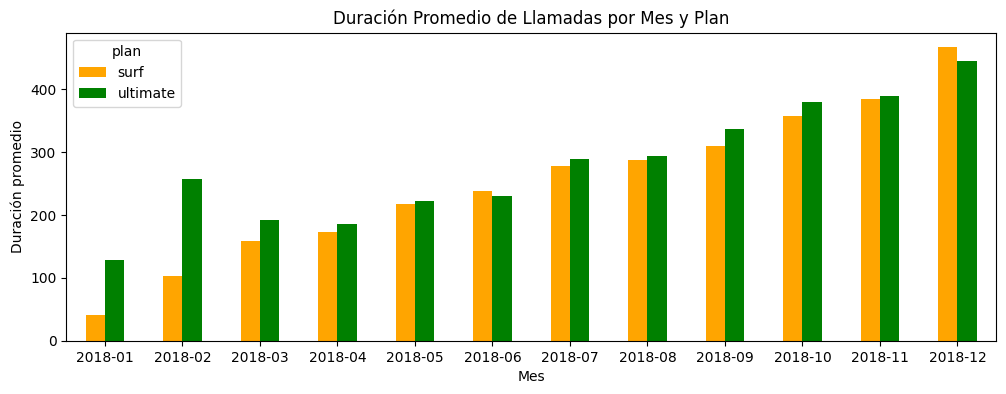

In [91]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

df_avg_call_duration_per_month = df_monthly_usage_plan.pivot_table(index = "month", # A partir del último df creado, se obtiene una tabla dinámica con las duraciones promedio por mes y plan.
                                                                  columns = "plan",
                                                                  values = "calls_duration",
                                                                  aggfunc = "mean")

#print(df_avg_call_duration_per_month) # Se visualiza la tabla dinámica.

df_avg_call_duration_per_month.plot(kind = "bar", # Se constuye la gráfica de barras que compara los dos planes.
                                   title = "Duración Promedio de Llamadas por Mes y Plan",
                                   xlabel = "Mes",
                                   ylabel = "Duración promedio",
                                   color = ["orange","green"],
                                   figsize = [12,4],
                                   rot = 0)

plt.show()

La anterior visualización muestra:

1. La duración promedio crece uniformemente conforme avanzan los meses con surf, es decir, los usuarios hablan más tiempo conforme avanza el año.
2. Ultimate por su lado, fluctua en los primeros tres meses, a partir del cuarto crece también uniformemente, es decir, los usuarios hablan más tiempo de enero a marzo que los de surf, pero a partir de abril crece uniforme.
3. Las duraciones promedio a partir de marzo son muy parecidas en ambos planes, indicando que sin importar el plan, los usuarios consumen minutos semejantes.

plan         surf  ultimate
month                      
2018-01     406.0     774.0
2018-02    2673.0    2822.0
2018-03    7590.0    3651.0
2018-04   17577.0    7074.0
2018-05   30768.0   11781.0
2018-06   41836.0   17435.0
2018-07   54448.0   25197.0
2018-08   66438.0   29922.0
2018-09   80360.0   37626.0
2018-10  101846.0   47778.0
2018-11  119801.0   56540.0
2018-12  150680.0   69324.0


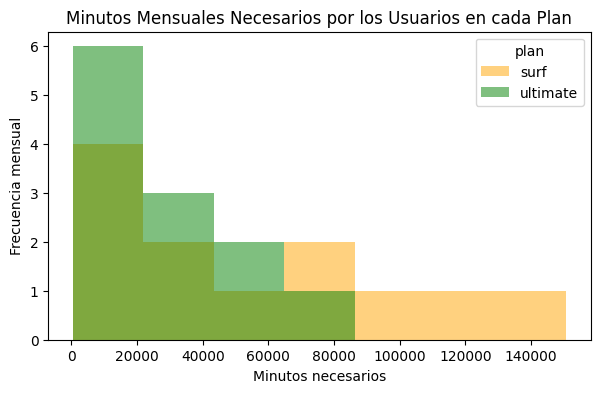

In [92]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

df_sum_call_duration_per_month = df_monthly_usage_plan.pivot_table(index = "month", # A partir del último df creado, se obtiene una tabla dinámica con la suma de las duraciones por mes y plan.
                                                                    columns = "plan",
                                                                    values = "calls_duration",
                                                                    aggfunc = "sum")

print(df_sum_call_duration_per_month) # Se visualiza el resultado de la tabla dinámica.

plt_call_duration = df_sum_call_duration_per_month.plot(kind = "hist", # Se constuye el histograma que compara los dos planes.
                                                        alpha = 0.5,
                                                        bins = 7,
                                                        color = ["orange","green"],
                                                        figsize = [7,4])

plt_call_duration.set_title("Minutos Mensuales Necesarios por los Usuarios en cada Plan")
plt_call_duration.set_xlabel("Minutos necesarios")
plt_call_duration.set_ylabel("Frecuencia mensual")

plt.show()

El histograma muestra:

1. En general, los usuarios con surf llegan a requerir más minutos al mes que aquellos con ultimate.
2. 3 meses del año los usuarios con surf requieren casi el doble de minutos que el máximo que requieren los de ultimate.
3. La frecuencia de meses decrece conforme aumentan los minutos requeridos en ambos planes.

In [93]:
# Calcula la media y la varianza de la duración mensual de llamadas.
print(df_sum_call_duration_per_month.describe())

plan            surf      ultimate
count      12.000000     12.000000
mean    56201.916667  25827.000000
std     49020.029427  22846.433388
min       406.000000    774.000000
25%     15080.250000   6218.250000
50%     48142.000000  21316.000000
75%     85731.500000  40164.000000
max    150680.000000  69324.000000


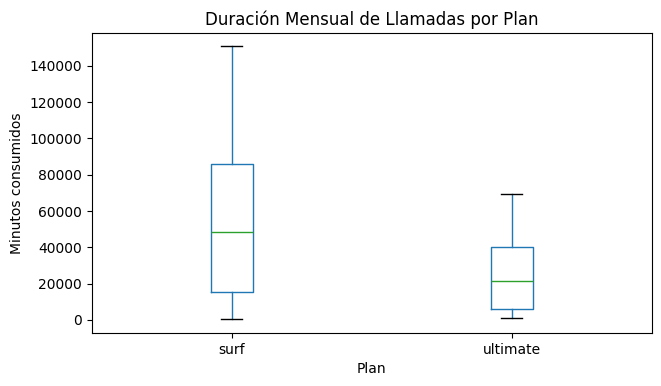

In [94]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

df_sum_call_duration_per_month_melt = df_sum_call_duration_per_month.reset_index().melt(id_vars = "month", # Haciendo uso de la última tabla dinámica creada, se transforma a formato largo.
                                                                                        value_vars = ["surf", "ultimate"],
                                                                                        var_name = "plan",
                                                                                        value_name = "calls_duration")

plt_call_duration_boxplot = df_sum_call_duration_per_month_melt.boxplot(column = "calls_duration", # Se cra el boxplot.
                                                                        by = "plan",
                                                                        grid = False,
                                                                        figsize = [7,4])

plt.suptitle("")
plt.title("Duración Mensual de Llamadas por Plan")
plt_call_duration_boxplot.set_xlabel("Plan")
plt_call_duration_boxplot.set_ylabel("Minutos consumidos")
plt.show()

Tras analizar el consumo de minutos en llamadas se observa:

1. Las duraciones promedio no varian significativamente por plan salvo ultimate que resulta más alto los primeros tres meses.
2. Los minutos totales consumidos al mes sí varía por plan, surf tiende a usar más minutos que ultimate.
3. Las distribuciones de entre ambos planes sí resultan distintas, el uso de los minutos en surf usa un rango mucho más amplio que ultimate, la media y mediana de surf llega a ser hasta el doble de las de ultimate, otra muestra de que el comportamiento es distinto.

### Mensajes

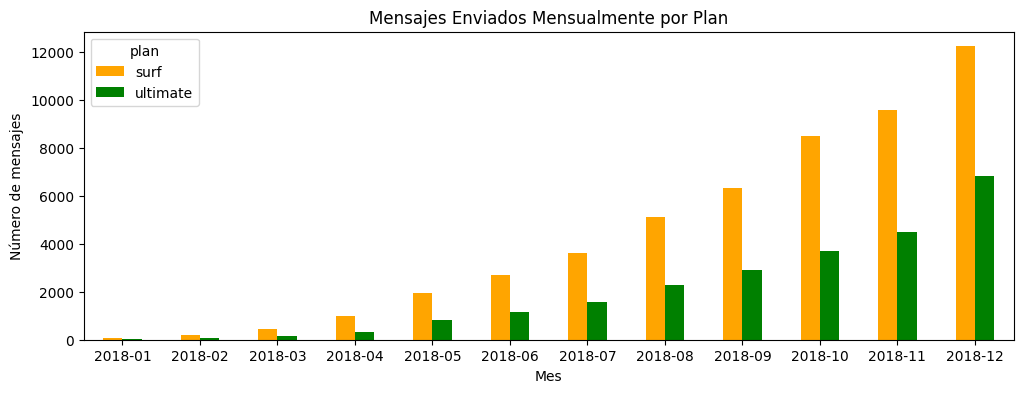

In [95]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

# El plan a seguir es mostrar visualizaciones semejantes al análisis hecho con las llamadas.

df_messages_per_month = df_monthly_usage_plan.pivot_table(index = "month",
                                                          columns = "plan",
                                                          values = "messages_number",
                                                          aggfunc = "sum")

#print(df_messages_per_month)

df_messages_per_month.plot(kind = "bar",
                           title = "Mensajes Enviados Mensualmente por Plan",
                           xlabel = "Mes",
                           ylabel = "Número de mensajes",
                           color = ["orange","green"],
                           figsize = [12,4],
                           rot = 0)

plt.show()

La última gráfica muestra:

1. El número de mensajes enviados crece exponencialmente mes a mes para ambos planes.
2. En cada mes se nota que las llamadas de surf duplica a las de ultimate.

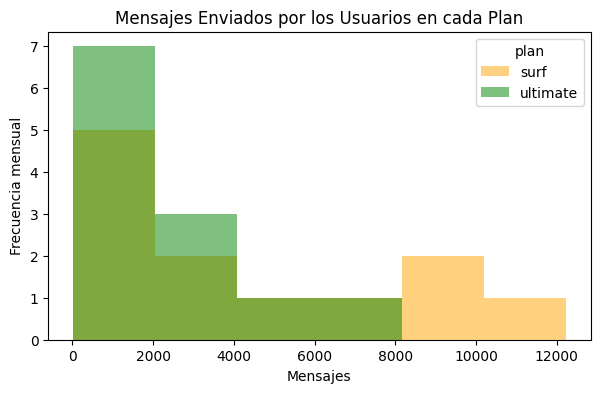

In [96]:
plt_df_messages_per_month = df_messages_per_month.plot(kind = "hist",
                                                       alpha = 0.5,
                                                       bins = 6,
                                                       color = ["orange","green"],
                                                       figsize = [7,4])

plt_df_messages_per_month.set_title("Mensajes Enviados por los Usuarios en cada Plan")
plt_df_messages_per_month.set_xlabel("Mensajes")
plt_df_messages_per_month.set_ylabel("Frecuencia mensual")

plt.show()

Del histograma anterior se tiene:

1. Semejante a los minutos, los usuarios con surf llegan a requerir enviar más mensajes al mes que aquellos con ultimate.
2. La frecuencia de meses decrece conforme aumentan los mensajes enviados en ambos planes salvo un mes en surf.

In [97]:
print(df_messages_per_month.describe())

plan           surf     ultimate
count     12.000000    12.000000
mean    4310.000000  2027.583333
std     4067.999642  2124.928853
min       73.000000    10.000000
25%      864.250000   284.000000
50%     3162.500000  1358.000000
75%     6860.750000  3109.750000
max    12229.000000  6842.000000


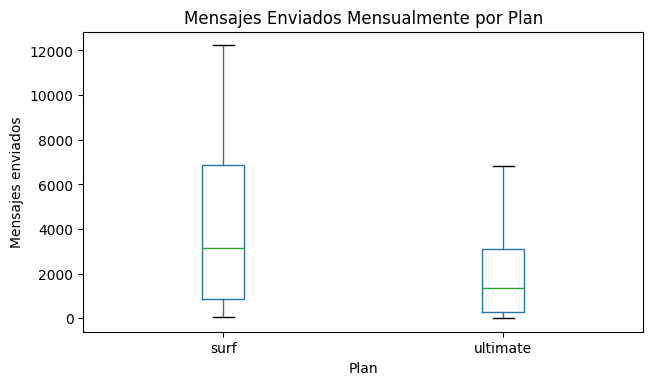

In [98]:
df_messages_per_month_melt = df_messages_per_month.reset_index().melt(id_vars = "month",
                                                                      value_vars = ["surf", "ultimate"],
                                                                      var_name = "plan",
                                                                      value_name = "used_messages")

plt_messages_boxplot = df_messages_per_month_melt.boxplot(column = "used_messages",
                                                          by = "plan",
                                                          grid = False,
                                                          figsize = [7,4])

plt.suptitle("")
plt.title("Mensajes Enviados Mensualmente por Plan")
plt_messages_boxplot.set_xlabel("Plan")
plt_messages_boxplot.set_ylabel("Mensajes enviados")
plt.show()

Tras analizar los mensajes enviados se observa:

1. Los envíos crecen exponencialemnte para cada plan y sí varían entre ellos, más precisamente, surf envía mensajes 2 veces más cada mes que ultimate.
2. Los promedios, desviaciones y medianas también muestran que surf es aproximádamente 2 veces más que ultimate.
3. Las distribuciones de entre ambos planes sí resultan distintas, surf envía mensajes en un rango mucho más amplio que ultimate, cuyo rango de valores es más acotado.

### Internet

plan     surf  ultimate
month                  
2018-01    10        29
2018-02   110       121
2018-03   312       221
2018-04   611       343
2018-05  1087       489
2018-06  1502       725
2018-07  2042       973
2018-08  2735      1267
2018-09  3238      1463
2018-10  4126      1878
2018-11  4650      2174
2018-12  5800      2778


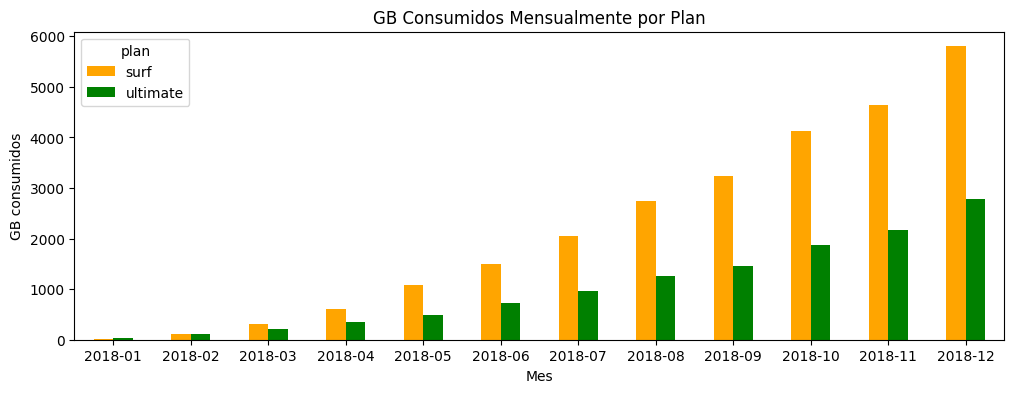

In [99]:
# Para analizar el consumo de internet, se procederá análogo a los anteriores puntos.

df_internet_per_month = df_monthly_usage_plan.pivot_table(index = "month",
                                                          columns = "plan",
                                                          values = "gb_used",
                                                          aggfunc = "sum")

print(df_internet_per_month)

df_internet_per_month.plot(kind = "bar",
                           title = "GB Consumidos Mensualmente por Plan",
                           xlabel = "Mes",
                           ylabel = "GB consumidos",
                           color = ["orange","green"],
                           figsize = [12,4],
                           rot = 0)

plt.show()

Con el anterior resultado:

1. Vemos un patrón similar al los mensajes enviados, el consumos de mb mes a mes es exponencial para ambos planes.
2. En cada mes se nota que el consumo de surf duplica a las de ultimate.

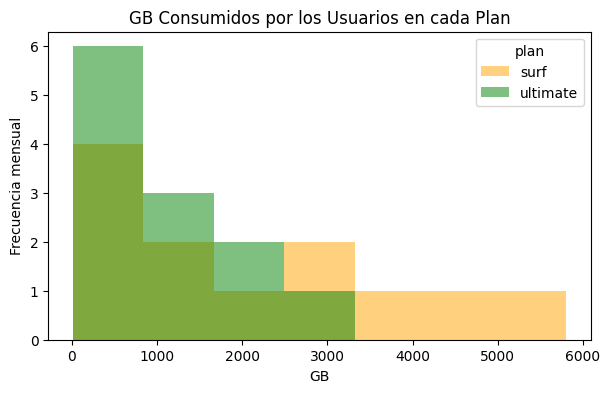

In [100]:
plt_df_internet_per_month = df_internet_per_month.plot(kind = "hist",
                                                       alpha = 0.5,
                                                       bins = 7,
                                                       color = ["orange","green"],
                                                       figsize = [7,4])

plt_df_internet_per_month.set_title("GB Consumidos por los Usuarios en cada Plan")
plt_df_internet_per_month.set_xlabel("GB")
plt_df_internet_per_month.set_ylabel("Frecuencia mensual")

plt.show()

In [101]:
print(df_internet_per_month.describe())

plan          surf     ultimate
count    12.000000    12.000000
mean   2185.250000  1038.416667
std    1931.500506   887.787798
min      10.000000    29.000000
25%     536.250000   312.500000
50%    1772.000000   849.000000
75%    3460.000000  1566.750000
max    5800.000000  2778.000000


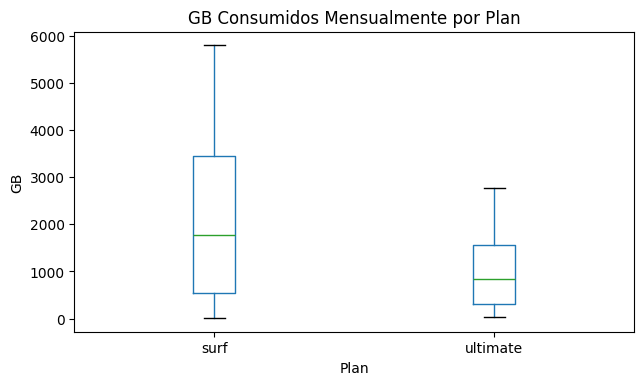

In [102]:
df_internet_per_month_melt = df_internet_per_month.reset_index().melt(id_vars = "month",
                                                                      value_vars = ["surf", "ultimate"],
                                                                      var_name = "plan",
                                                                      value_name = "used_gb")

plt_internet_boxplot = df_internet_per_month_melt.boxplot(column = "used_gb",
                                                          by = "plan",
                                                          grid = False,
                                                          figsize = [7,4])

plt.suptitle("")
plt.title("GB Consumidos Mensualmente por Plan")
plt_internet_boxplot.set_xlabel("Plan")
plt_internet_boxplot.set_ylabel("GB")
plt.show()

Las graficas anteriores muestran:

1. El promedio de gb consumidos con surf es casi el doble que el promedio por ultimate, indicando más consumo por surf.
2. La descviación estandar de surf es considerablemente mayor que con ultimate, esto sugiere mayor variación en sus consumos mensuales que con ultimate.
3. La variación anterior mencionada para surf puede deberse a los mínimos y máximos en su rango, mientras que ultimate cuenta con un patrón de consumo más estable.
4. El crecimiento en el consumo de gb, incrementa sin duda mes tras mes y se nota que surf consume hasta 2 veces más que ultimate.

## Ingreso

plan         surf  ultimate
month                      
2018-01    200.00     420.0
2018-02    649.33     770.0
2018-03   1556.26    1386.0
2018-04   3072.92    2723.0
2018-05   4959.03    3731.0
2018-06   6349.72    5397.0
2018-07   9075.91    6202.0
2018-08  11735.65    7343.0
2018-09  12626.02    8015.0
2018-10  16484.24    9065.0
2018-11  17036.13   10367.0
2018-12  22608.06   11417.0


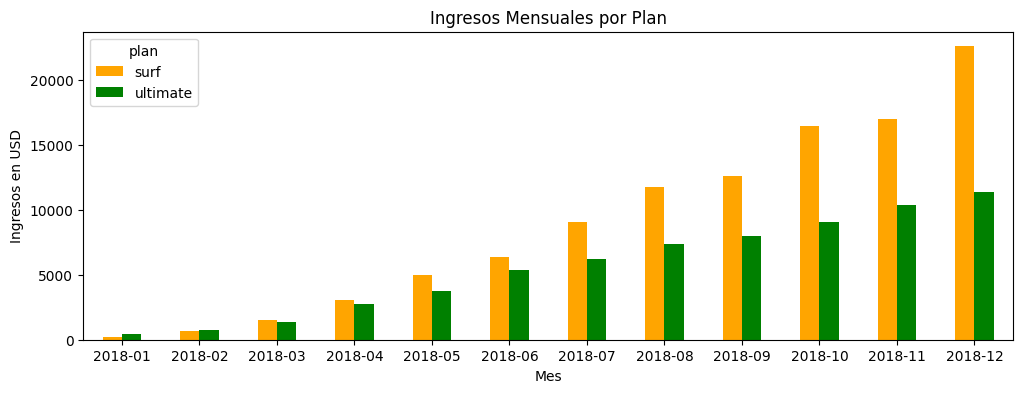

In [103]:
df_usd_per_month = df_monthly_usage_plan.pivot_table(index = "month",
                                                      columns = "plan",
                                                      values = "usd_monthly_payment",
                                                      aggfunc = "sum")

print(df_usd_per_month)

df_usd_per_month.plot(kind = "bar",
                      title = "Ingresos Mensuales por Plan",
                      xlabel = "Mes",
                      ylabel = "Ingresos en USD",
                      color = ["orange","green"],
                      figsize = [12,4],
                      rot = 0)

plt.show()

plan           surf      ultimate
count     12.000000     12.000000
mean    8862.772500   5569.666667
std     7306.602077   3784.180404
min      200.000000    420.000000
25%     2693.755000   2388.750000
50%     7712.815000   5799.500000
75%    13590.575000   8277.500000
max    22608.060000  11417.000000


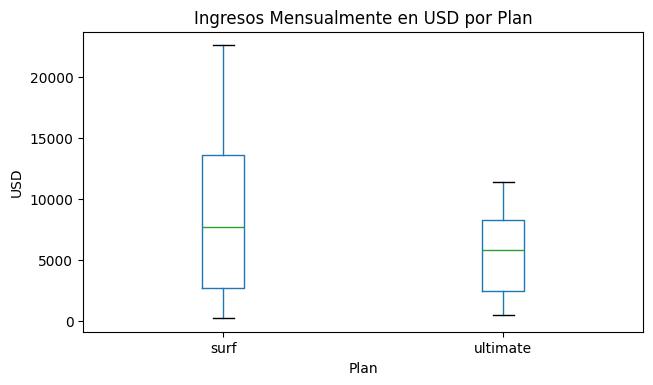

Los ingresos anuales corresponen a 106353.27 para el plan surf y 66836.0 para el plan ultimate.


In [104]:
print(df_usd_per_month.describe())

df_usd_per_month_melt = df_usd_per_month.reset_index().melt(id_vars = "month",
                                                            value_vars = ["surf", "ultimate"],
                                                            var_name = "plan",
                                                            value_name = "usd_income")

plt_usd_boxplot = df_usd_per_month_melt.boxplot(column = "usd_income",
                                                by = "plan",
                                                grid = False,
                                                figsize = [7,4])

plt.suptitle("")
plt.title("Ingresos Mensualmente en USD por Plan")
plt_usd_boxplot.set_xlabel("Plan")
plt_usd_boxplot.set_ylabel("USD")
plt.show()

surf_income = df_usd_per_month["surf"].sum()
ultimate_income = df_usd_per_month["ultimate"].sum()
print(f"Los ingresos anuales corresponen a {surf_income.round(2)} para el plan surf y {ultimate_income.round(2)} para el plan ultimate.")

Tras revisar los ingresos mensuales:

1. Se muestra un claro aumento mes a mes en los ingresos para ambos planes, llegando a su pico máximo en diciembre.
2. Comparando los ingresos entre los dos planes, se confirma que surf regularmente supera los ingresos de ultimate. Más aún, surf muestra una mayor variabilidad por tener incrementos más amplios a partir de julio, mientras que ultimate crece gradual y estable.
3. Surf en enero genera menos que ultimate, pero el diciembre mucho más, esta variabilidad se explica con la desviación estándar más alta en surf, ya que pasa de valores muy bajos hsata muy altos.
4. Entre septiembre y diciembre que ocurren los crecimientos más altos con surf que con ultimate (12,564.10 a 22,465.35, frente a 8,015.00 y 11,417.00 en Ultimate) podría ser un indicador de que surf es más atractivo para los cliente en meses de lata demanda.
5. En general, surf genera hasta 2 veces más ingresos que ultimate a lo largo del año.

## Prueba las hipótesis estadísticas

In [105]:
# Prueba las hipótesis

# Se define la hipótesis nula H_0 como "No hay diferencia en los ingresos promedio de los planes surf y ultimate".
# Se define la hipótesis alternativa H_1 como "Los ingresos promedio de los planes surf y ultimate son diferentes".

surf_income = df_monthly_usage_plan[df_monthly_usage_plan["plan"] == "surf"]["usd_monthly_payment"]
ultimate_income = df_monthly_usage_plan[df_monthly_usage_plan["plan"] == "ultimate"]["usd_monthly_payment"]

alpha = 0.05
result = st.ttest_ind(surf_income, ultimate_income, equal_var = False)
print('Valor p:', result.pvalue)

if result.pvalue < alpha:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa en los ingresos promedio.")
else:
    print("No rechazamos la hipótesis nula: no hay una diferencia significativa en los ingresos promedio.")

Valor p: 1.6649659138659566e-71
Rechazamos la hipótesis nula: hay una diferencia significativa en los ingresos promedio.


In [106]:
# Prueba las hipótesis

# Se define la hipótesis nula H_0 como "El ingreso promedio de los usuarios de NY-NJ es igual al de los usuarios de otras regiones".
# Se define la hipótesis alternativa H_1 como "El ingreso promedio de los usuarios de NY-NJ es diferente al de los usuarios de otras regiones".

ny_nj_income = df_monthly_usage_plan[df_monthly_usage_plan["city"].str.contains("NY-NJ")]["usd_monthly_payment"]
opposite_ny_nj_income = df_monthly_usage_plan[~df_monthly_usage_plan["city"].str.contains("NY-NJ")]["usd_monthly_payment"]

alpha_2 = 0.07
result = st.ttest_ind(ny_nj_income, opposite_ny_nj_income, equal_var = False)
print('Valor p:', result.pvalue)

if result.pvalue < alpha_2:
    print("Rechazamos la hipótesis nula: hay una diferencia en el ingreso promedio entre NY-NJ y otras regiones.")
else:
    print("No rechazamos la hipótesis nula: no hay una diferencia en el ingreso promedio entre NY-NJ y otras regiones.")

Valor p: 0.06581098108418706
Rechazamos la hipótesis nula: hay una diferencia en el ingreso promedio entre NY-NJ y otras regiones.


## Conclusión general

El análisis elaborado a lo largo del proyecto nos muestra las siguientes conclusiones y enseñanzas:

1. Mayor Consumo en Surf: El plan Surf muestra consumos significativamente mayores en minutos de llamada, mensajes enviados y megabytes de internet comparándolo con el plan Ultimate.
2. Variabilidad del Consumo: Surf presenta mayor variabilidad en el consumo de sus servicios, lo que puede indicarque que tienen patrones de uso más diversos y altos.
3. Crecimiento Exponencial: Ambos planes experimentan un crecimiento mensual, pero especialmente Surf registra incrementos pronunciados, especialmente en los meses que tienen alta demanda.
4. Ingresos Superiores: Los ingresos mensuales del plan Surf superan a los de Ultimate, con una variabilidad notable en Surf que permite ingresos más altos en los meses de septiembre a diciembre.
5. Diferencias: Las pruebas de hipótesis confirman diferencias significativas en los ingresos promedio entre ambos planes y entre regiones, mostrando que es más atractivo y generando mayores ingresos los del plan Surf.
6. Meses Altos: Surf muestra un aumento elevado en ingresos y de consumo durante los meses de alta demanda, indicando que es más atractivo para los clientes en los últimos meses del año.